# Importing libraries, loading and transforming data

In [1]:
!pip install -U -q mlflow datasets>=2.14.5 nlp 2>/dev/null

In [2]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import gc  # For garbage collection to manage memory
import re  # For regular expressions
import numpy as np  # For numerical operations and arrays

import warnings  # For handling warnings
warnings.filterwarnings("ignore")  # Ignore warning messages

import torch  # PyTorch library for deep learning
from transformers import AutoModel, AutoTokenizer  # Transformers library for natural language processing
from transformers import TextDataset, LineByLineTextDataset, DataCollatorForLanguageModeling, \
pipeline, Trainer, TrainingArguments, DataCollatorWithPadding  # Transformers components for text processing
from transformers import AutoModelForSequenceClassification  # Transformer model for sequence classification

#from nlp import Dataset  # Import custom 'Dataset' class for natural language processing tasks
from imblearn.over_sampling import RandomOverSampler  # For oversampling to handle class imbalance
import datasets  # Import datasets library
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import pipeline  # Transformers library for pipelines
from bs4 import BeautifulSoup  # For parsing HTML content

import matplotlib.pyplot as plt  # For data visualization
import itertools  # For working with iterators
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

from datasets import load_metric  # Import load_metric function to load evaluation metrics

from tqdm import tqdm  # For displaying progress bars
tqdm.pandas()  # Enable progress bars for pandas operations

In [3]:
# Set parameters for training a news category classifier using DistilBERT

# Fraction of the dataset used for training, the rest will be used for validation
train_fraction = 0.8

# Number of training epochs
num_train_epochs = 2

# Learning rate
learning_rate = 2e-6

# Batch size for training
train_batch_size = 8

# Batch size for validation
eval_batch_size = 64

# Number of warm-up steps during training
warmup_steps = 50

# Weight decay to control regularization during training
weight_decay = 0.02

# Pre-trained BERT model to be used
BERT_MODEL = "bert-base-uncased"

# Directory where the model output will be saved
output_dir = "sarcasm-detection-distilbert"

In [4]:
%%time
# Read the CSV file into a DataFrame
df = pd.read_csv("/kaggle/input/sarcasm/train-balanced-sarcasm.csv")

item0 = df.shape[0]  # Store the initial number of items in the DataFrame
df = df.drop_duplicates()  # Remove duplicate rows from the DataFrame
item1 = df.shape[0]  # Store the number of items in the DataFrame after removing duplicates
print(f"There are {item0-item1} duplicates found in the dataset")  # Print the number of duplicates removed

# select label as sarcasm
def label_sarcasm(x):
    if x > 0:
        return 'Sarcasm'
    elif x == 0:
        return 'No sarcasm'
df['label'] = df['label'].apply(label_sarcasm)

df = df.rename(columns={'comment': 'title'})  # Rename the columns to standard ones

df = df[['label', 'title']]  # Select only the 'label' and 'title' columns
df = df[~df['title'].isnull()]  # Remove rows where 'title' is null
df = df[~df['label'].isnull()]  # Remove rows where 'label' is null

print(df.shape)  # Print the shape of the DataFrame after data preprocessing
df.sample(5).T  # Display a random sample of 5 rows from the DataFrame

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/sarcasm/train-balanced-sarcasm.csv'

In [5]:
# Import the necessary library to compute class weights.
from sklearn.utils.class_weight import compute_class_weight

# Identify the unique classes in the training data.
classes = np.unique(df[['label']])

print(classes)

# Calculate class weights using the 'balanced' option, which automatically adjusts for class imbalance.
weights = compute_class_weight(class_weight='balanced', classes=classes, y=df['label'])

# Create a dictionary mapping each class to its respective class weight.
class_weights = dict(zip(classes, weights))

# Print the computed class weights to the console.
print(class_weights)

['No sarcasm' 'Sarcasm']
{'No sarcasm': 0.9999376735001573, 'Sarcasm': 1.0000623342699964}


In [6]:
# Create a list of unique labels
labels_list = sorted(list(df['label'].unique()))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'No sarcasm', 1: 'Sarcasm'} 

Mapping of Labels to IDs: {'No sarcasm': 0, 'Sarcasm': 1}


In [7]:
ordered_weigths = [class_weights[x] for x in id2label.values()]
ordered_weigths

[0.9999376735001573, 1.0000623342699964]

In [8]:
# Create a dataset from the Pandas DataFrame 'df'
dataset = Dataset.from_pandas(df)

In [9]:
# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Splitting the dataset into training and testing sets using the predefined train/test split ratio.
dataset = dataset.train_test_split(test_size=1-train_fraction, shuffle=True, stratify_by_column="label")

# Extracting the training data from the split dataset.
df_train = dataset['train']

# Extracting the testing data from the split dataset.
df_test = dataset['test']

Map:   0%|          | 0/1010743 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1010743 [00:00<?, ? examples/s]

In [10]:
# Deleting the DataFrame 'df'
del df

# Performing garbage collection to free up memory
gc.collect()

22

In [11]:
# Create a tokenizer instance for the specified BERT model.
# - 'AutoTokenizer.from_pretrained' loads the pre-trained tokenizer for the specified model.
# - 'use_fast=True' enables fast tokenization, which is recommended for most use cases.
# - 'low_cpu_mem_usage=False' disables low CPU memory usage mode (useful for larger models).
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL, use_fast=True, low_cpu_mem_usage=False)

In [12]:
# Importantly, this is a simple function for preprocessing data before training a natural language processing model.
# It takes a dataset of examples as input.

def preprocess_function(examples):
    # The main task of this function is to tokenize the text data in the 'title' column of the examples.
    # Tokenization is the process of breaking down text into smaller units, such as words or subwords.
    # In this case, the tokenizer is applied to each 'title' in the examples.

    # The 'truncation=True' parameter indicates that if a title is too long to fit within the model's maximum input length,
    # it should be truncated to fit. Truncation can help ensure that the input data is within the model's capacity.

    return tokenizer(examples["title"], truncation=True)

# The code below applies the preprocess_function to two dataframes, df_train and df_test.

# df_train is likely a training dataset, and df_test is likely a testing dataset.
# These datasets contain examples with a 'title' field that we want to tokenize for further processing.

# The 'map' function is used to apply the preprocess_function to each example in the datasets.
# The 'batched=True' parameter indicates that the tokenization should be applied in batches for efficiency.

df_train = df_train.map(preprocess_function, batched=True)
df_test = df_test.map(preprocess_function, batched=True)

Map:   0%|          | 0/808594 [00:00<?, ? examples/s]

Map:   0%|          | 0/202149 [00:00<?, ? examples/s]

In [13]:
# Remove the 'title' column from the training dataset.
df_train = df_train.remove_columns(['title'])

# Remove the 'title' column from the testing dataset.
df_test = df_test.remove_columns(['title'])

In [14]:
df_train

Dataset({
    features: ['label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 808594
})

In [15]:
df_test

Dataset({
    features: ['label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 202149
})

In [16]:
# DataCollatorWithPadding creates batch of data. It also dynamically pads text to the 
#  length of the longest element in the batch, making them all the same length. 
#  It's possible to pad your text in the tokenizer function with padding=True, dynamic padding is more efficient.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [17]:
# Retrieve the 'input_ids' from the first row of the DataFrame 'df_train'
tokenizer.decode(df_train[0]['input_ids'])

'[CLS] food of varying levels of digestion [SEP]'

# Loading and training model

In [18]:
# Load a pre-trained BERT-based model for sequence classification.
model = AutoModelForSequenceClassification.from_pretrained(
    BERT_MODEL, num_labels=len(labels_list),
    output_attentions=False,  # Set to False: Model will not return attention weights.
    output_hidden_states=False  # Set to False: Model will not return all hidden-states.
)

# Configure the mapping of class labels to their corresponding indices for later reference.
model.config.id2label = id2label  # Mapping from label indices to class labels.
model.config.label2id = label2id  # Mapping from class labels to label indices.

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


109.483778


In [19]:
# Import the 'load_metric' function from the Hugging Face datasets library to load a metric.
metric = load_metric("accuracy")

# Define a custom 'compute_metrics' function that will be used for evaluating model performance.
# This function takes 'eval_pred' as input, which is a tuple containing predicted logits and true labels.
def compute_metrics(eval_pred):
    # Unpack the 'eval_pred' tuple into 'logits' (predicted logits) and 'labels' (true labels).
    logits, labels = eval_pred
    
    # Calculate the model's predictions by selecting the class with the highest logit value.
    predictions = np.argmax(logits, axis=-1)
    
    # Use the imported metric to compute the accuracy of the model's predictions.
    accuracy = metric.compute(predictions=predictions, references=labels)
    
    # Return the computed accuracy as the evaluation metric.
    return accuracy

In [20]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has labels with different weights)
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(ordered_weigths, device=model.device).float())
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [21]:
# Create TrainingArguments to configure the training process
training_args = TrainingArguments(
    output_dir=output_dir,  # Directory to save the model checkpoints and logs
    logging_dir='./logs',  # Directory to store training logs
    num_train_epochs=num_train_epochs,  # Number of training epochs
    per_device_train_batch_size=train_batch_size,  # Batch size for training data
    per_device_eval_batch_size=eval_batch_size,  # Batch size for evaluation data
    logging_strategy='steps',  # Logging frequency during training (steps or epoch)
    logging_first_step=True,  # Log the first training step
    load_best_model_at_end=True,  # Load the best model at the end of training
    logging_steps=1,  # Log every training step (useful for debugging)
    learning_rate=learning_rate, # Set the learning rate for the optimizer.
    evaluation_strategy='epoch',  # Evaluation frequency (epoch or steps)
    warmup_steps=warmup_steps,  # Number of warmup steps for the learning rate
    weight_decay=weight_decay,  # Weight decay for regularization
    eval_steps=1,  # Evaluate every training step (useful for debugging)
    save_strategy='epoch',  # Save model checkpoints every epoch
    save_total_limit=1,  # Limit the number of saved checkpoints to save space
    report_to="mlflow",  # Log training metrics to MLflow
)

# Define the trainer:
# Instantiate the trainer class and configure its settings
trainer = WeightedTrainer(
    model=model,  # The pretrained or custom model to be trained
    args=training_args,  # TrainingArguments for configuring training
    compute_metrics=compute_metrics,  # Function for computing evaluation metrics
    train_dataset=df_train,  # Training dataset
    eval_dataset=df_test,  # Evaluation dataset
    data_collator=data_collator  # Data collator for batching and preprocessing
)

In [22]:
# Get initial metrics
trainer.evaluate()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.7674027681350708,
 'eval_accuracy': 0.5000321544998986,
 'eval_runtime': 371.5285,
 'eval_samples_per_second': 544.101,
 'eval_steps_per_second': 8.503}

In [23]:
# Start training the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.187200,0.496558,0.766296
2,0.584400,0.485706,0.772638


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



TrainOutput(global_step=202150, training_loss=0.49454042141197924, metrics={'train_runtime': 13600.5266, 'train_samples_per_second': 118.906, 'train_steps_per_second': 14.863, 'total_flos': 2.712593066890068e+16, 'train_loss': 0.49454042141197924, 'epoch': 2.0})

In [24]:
# Final model evaluation
trainer.evaluate()

{'eval_loss': 0.48570626974105835,
 'eval_accuracy': 0.7726380046401417,
 'eval_runtime': 377.352,
 'eval_samples_per_second': 535.704,
 'eval_steps_per_second': 8.371,
 'epoch': 2.0}

In [25]:
# Use the trained 'trainer' to make predictions on the 'df_test'.
outputs = trainer.predict(df_test)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 0.48570626974105835, 'test_accuracy': 0.7726380046401417, 'test_runtime': 377.391, 'test_samples_per_second': 535.649, 'test_steps_per_second': 8.371}


Accuracy: 0.7726
F1 Score: 0.7726


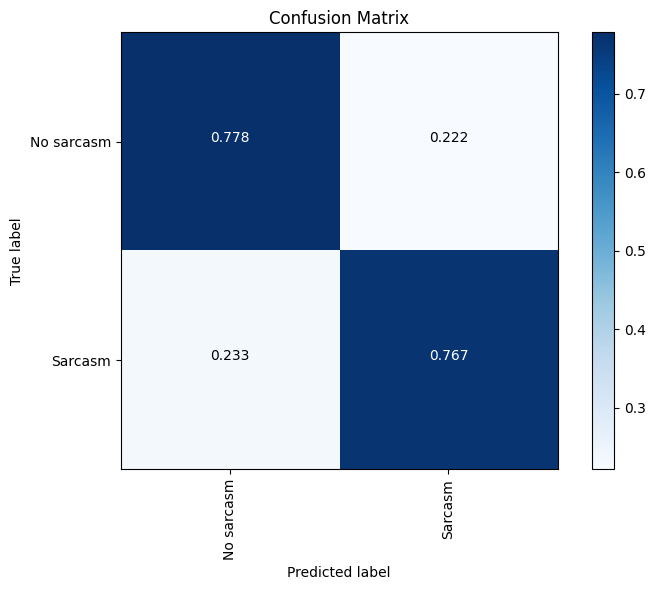


Classification report:

              precision    recall  f1-score   support

  No sarcasm     0.7696    0.7783    0.7739    101081
     Sarcasm     0.7757    0.7670    0.7713    101068

    accuracy                         0.7726    202149
   macro avg     0.7727    0.7726    0.7726    202149
weighted avg     0.7727    0.7726    0.7726    202149



In [26]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8), is_norm=True):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    if is_norm:
        fmt = '.3f'
    else:
        fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a relatively small number of labels
if len(labels_list) <= 120:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

# Saving the model and checking its performance with a sample input

In [27]:
trainer.save_model()

In [28]:
tokenizer.save_vocabulary(save_directory=f"./{output_dir}")

('./sarcasm-detection-distilbert/vocab.txt',)

In [29]:
# Make a classification pipeline and test with the sample input
pipe = pipeline("text-classification", output_dir, tokenizer=BERT_MODEL)
sample_title = '''Elon Musk buys Twitter'''
pipe(sample_title, top_k=10)

[{'label': 'No sarcasm', 'score': 0.5141810178756714},
 {'label': 'Sarcasm', 'score': 0.4858190417289734}]

# Send model to Huggingface

In [30]:
# finally, save the model to Huggingface
from huggingface_hub import notebook_login
notebook_login()

In [31]:
from huggingface_hub import HfApi
api = HfApi()
repo_id = f"dima806/{output_dir}"
try:
    api.create_repo(repo_id)
    print(f"Repo {repo_id} created")
except:
    print(f"Repo {repo_id} already exists")

Repo dima806/sarcasm-detection-distilbert created


In [32]:
api.upload_folder(
    folder_path=output_dir,
    path_in_repo = ".",
    repo_id=repo_id,
    repo_type="model"
)

optimizer.pt:   0%|          | 0.00/876M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

Upload 8 LFS files:   0%|          | 0/8 [00:00<?, ?it/s]

trainer_state.json:   0%|          | 0.00/24.8M [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/627 [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

'https://huggingface.co/dima806/sarcasm-detection-distilbert/tree/main/.'